In [7]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.cm import Set3
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis Goals

We want to figure out what factors affect employee retention. 

In [8]:
data = pd.read_csv('data/employee_retention_data.csv',
                   parse_dates=['join_date', 'quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


# Pre-Processing
Let's do some basic exploration. I'm going to pre-process the data in the following ways:

1. Create a `days_in_job` column that corresponds to the number of days a person has been in their job.
1. Re-compute the `salary` column so that it is divided by 1,000.
1. Create a `censored` column that corresponds to whether we have observed that employee quit or not.

In [9]:
from datetime import datetime, date


def fill_nat(x):
    if pd.isnull(x['days_in_job']):
        return (datetime.today() - x['join_date']).days
    else:
        return (x['days_in_job']).days


data['days_in_job'] = data['quit_date'] - data['join_date']
data['days_in_job'] = data.apply(lambda x: fill_nat(x), axis=1)
data['salary'] = data['salary'] / 1000
data['censored'] = pd.isnull(data['quit_date'])

# Exploratory Analysis

Before we go on, let's look at some basic distributions of the data. Firstly, let's look at the seniority and salary distributions.

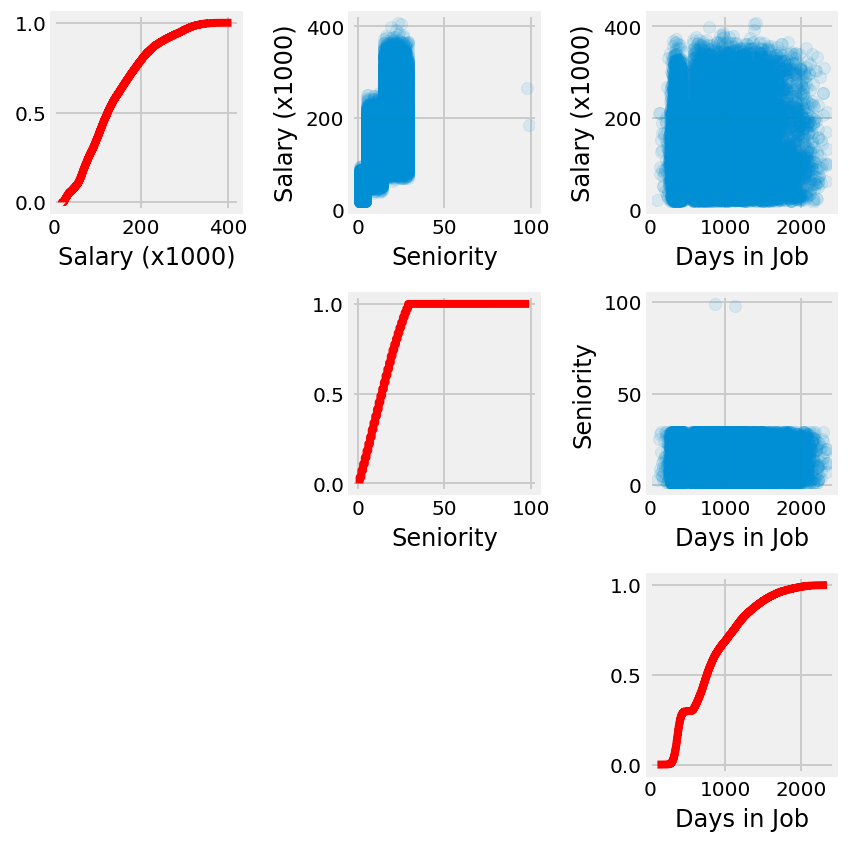

In [10]:
def ecdf_scatter(data):
    """
    Utility function that returns the ECDF of two variables.
    """
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

fig = plt.figure(figsize=(6,6))
gs = GridSpec(3, 3)
ax_salary = fig.add_subplot(gs[0, 0])
x, y = ecdf_scatter(data['salary'])
ax_salary.plot(x, y, color='red')
ax_salary.set_xlabel('Salary (x1000)')

ax_seniority = fig.add_subplot(gs[1,1])
x, y = ecdf_scatter(data['seniority'])
ax_seniority.plot(x, y, color='red')
ax_seniority.set_xlabel('Seniority')

ax_days = fig.add_subplot(gs[2,2])
x, y = ecdf_scatter(data['days_in_job'])
ax_days.plot(x, y, color='red')
ax_days.set_xlabel('Days in Job')

ax_salary_seniority = fig.add_subplot(gs[0, 1])
ax_salary_seniority.scatter(data['seniority'], data['salary'], alpha=0.1)
ax_salary_seniority.set_xlabel('Seniority')
ax_salary_seniority.set_ylabel('Salary (x1000)')

ax_seniority_days = fig.add_subplot(gs[1, 2])
ax_seniority_days.scatter(data['days_in_job'], data['seniority'], alpha=0.1)
ax_seniority_days.set_xlabel('Days in Job')
ax_seniority_days.set_ylabel('Seniority')

ax_salary_days = fig.add_subplot(gs[0, 2])
ax_salary_days.scatter(data['days_in_job'], data['salary'], alpha=0.1)
ax_salary_days.set_xlabel('Days in Job')
ax_salary_days.set_ylabel('Salary (x1000)')

plt.tight_layout()

What we see is that: 

- the distribution of the number of days in job is bimodal,
- seniority has some outliers near or at 100 years, and 
- salary is a smooth distribution. 

In addition to that, there's little relationship between salary and days in job, and seniority and days in job. These simple factors alone are unlikely to be predictive of when an employee is going to leave.

# Head Count over Time

I'm now going to try to measure head count over time for each company. To do this, we will go day by day from day 0 (2011-01-23), and check how each company's total head count has changed over time.

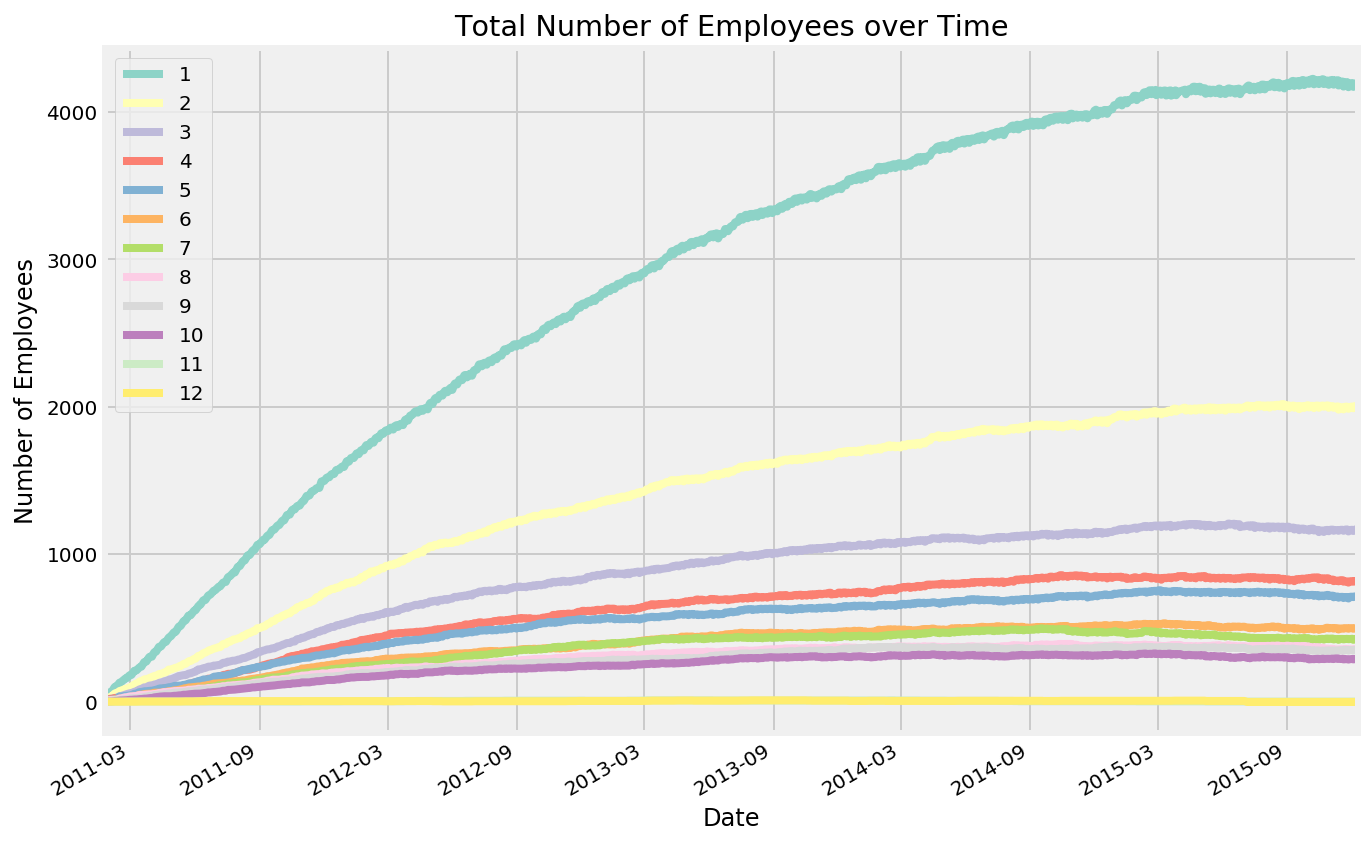

In [12]:
def fill_company_id(x):
    if pd.isnull(x['company_id_add']):
        return x['company_id_rem']
    else:
        return x['company_id_add']


additions = (data.groupby(['company_id', 'join_date'])
             .count()['employee_id']
             .reset_index())
additions.columns = ['company_id', 'date', 'number_added']
additions.set_index('date', inplace=True)

removals = (data.groupby(['company_id', 'quit_date'])
            .count()['employee_id']
            .reset_index())
removals.columns = ['company_id', 'date', 'number_removed']
removals.set_index('date', inplace=True)

net_headcounts = additions.join(removals, how='outer', lsuffix='_add',
                                rsuffix='_rem')
net_headcounts['company_id'] = (net_headcounts
                                .apply(lambda x: fill_company_id(x), axis=1))
del net_headcounts['company_id_add']
del net_headcounts['company_id_rem']
net_headcounts.fillna(0, inplace=True)
net_headcounts['net_growth'] = (net_headcounts['number_added'] -
                                net_headcounts['number_removed'])
net_headcounts.reset_index(inplace=True)

headcounts_over_time = (net_headcounts.pivot_table(
    index=['date', 'company_id'],
    values='net_growth')
    .unstack(level=-1)
    .fillna(0)
    .cumsum())['net_growth']
headcounts_over_time.columns = [i for i in range(1, 13)]
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
headcounts_over_time.plot(ax=ax, cmap=Set3)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Employees')
ax.set_title('Total Number of Employees over Time')

# Net Additions and Removals Over Time

Now, we want to see how many employees were added over time and removed over time.

## Net Additions

Let's start first with net additions.

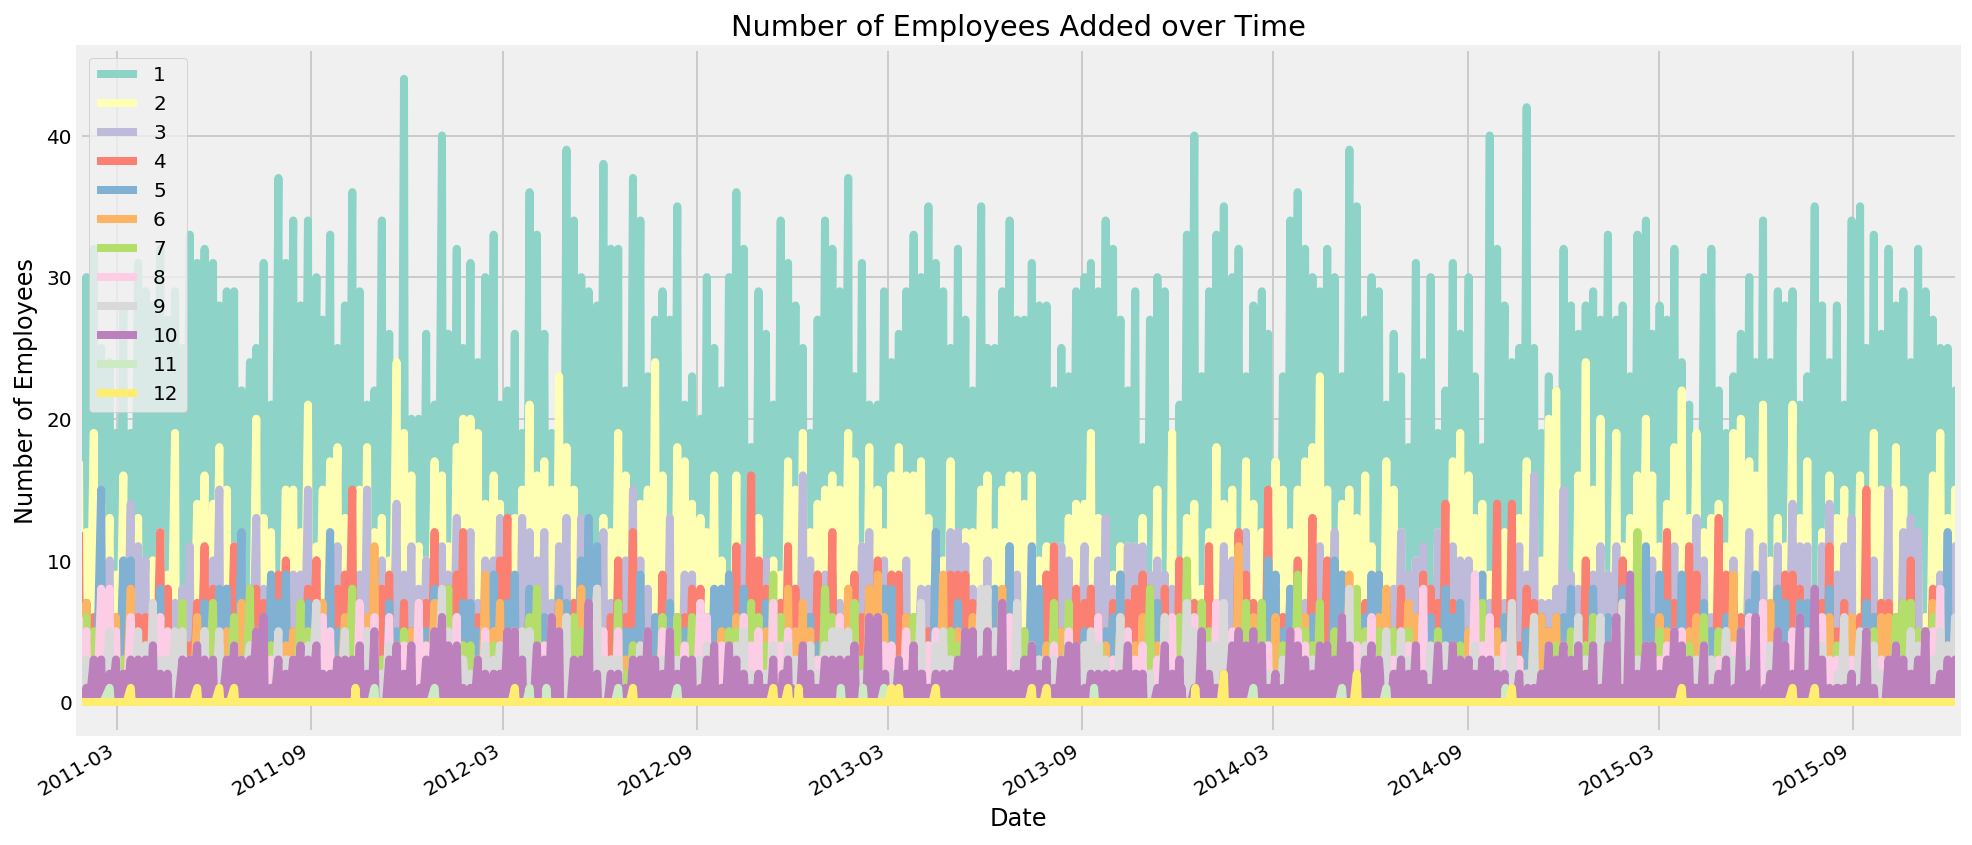

In [13]:
added_over_time = (net_headcounts.pivot_table(index=['date', 'company_id'],
                                              values='number_added')
                   .unstack(level=-1))
added_over_time.columns = [i for i in range(1, 13)]
added_over_time.fillna(0, inplace=True)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
added_over_time.plot(ax=ax, cmap=Set3)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Employees')
ax.set_title('Number of Employees Added over Time')

## Net Removals

Now, let's look at net removals over time.

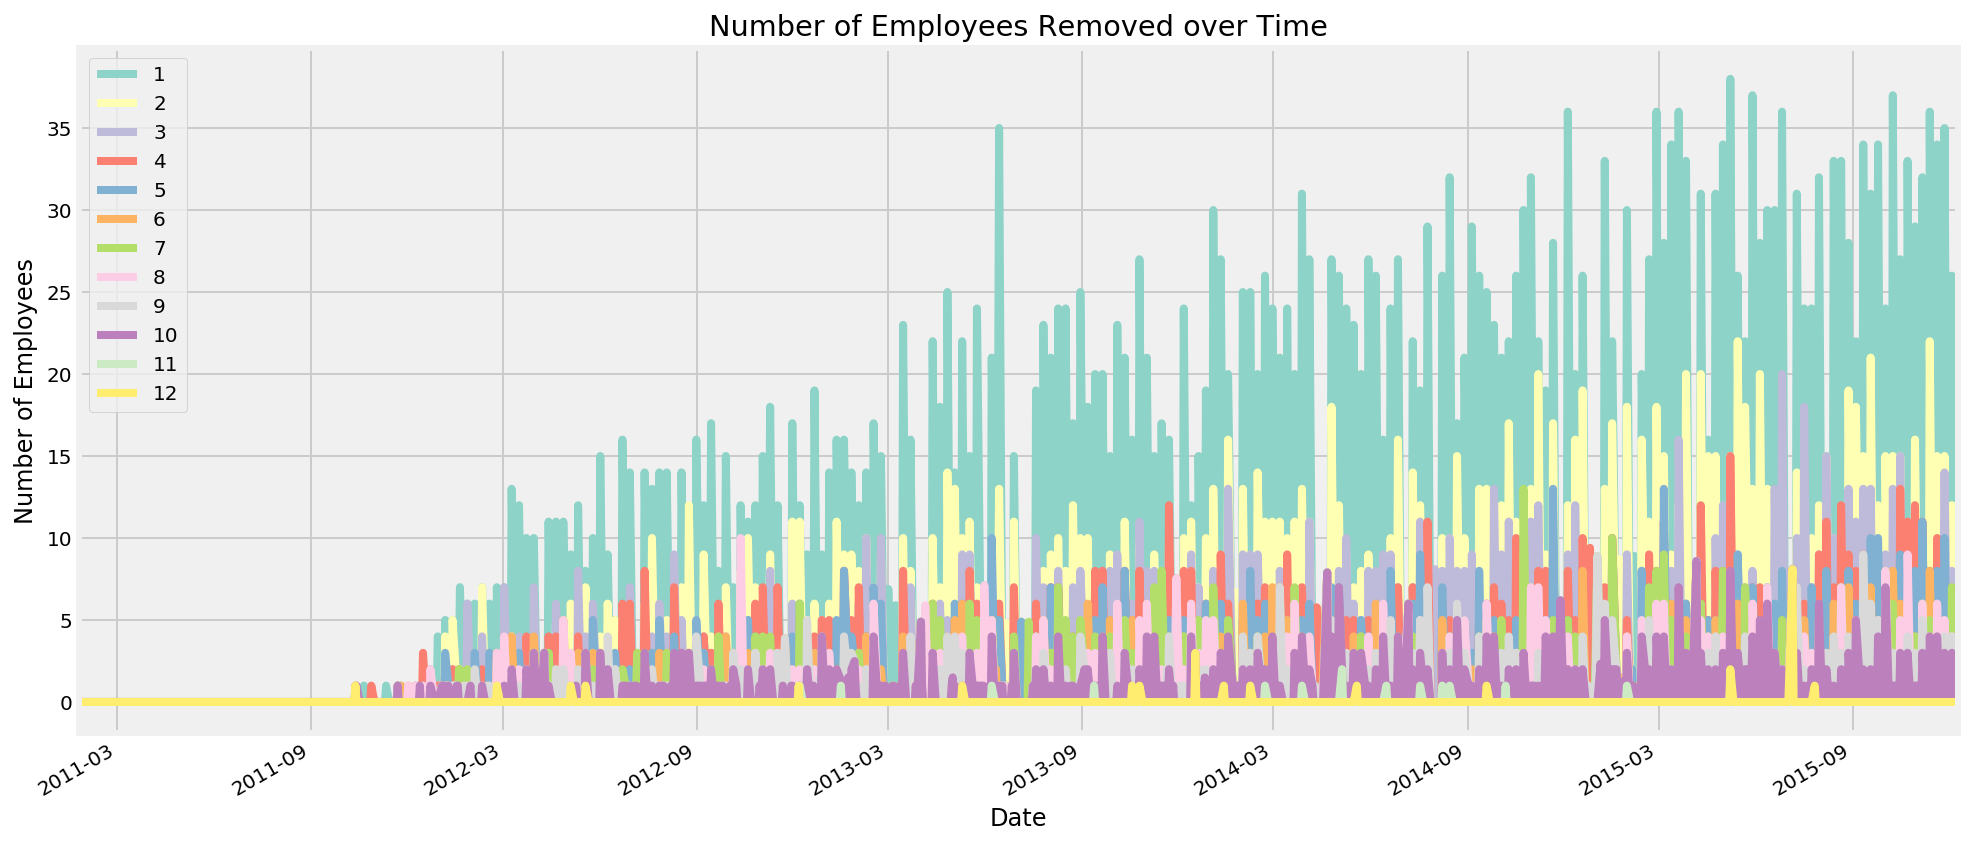

In [14]:
removed_over_time = (net_headcounts.pivot_table(index=['date', 'company_id'],
                                                values='number_removed')
                     .unstack(level=-1))
removed_over_time.columns = [i for i in range(1, 13)]
removed_over_time.fillna(0, inplace=True)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
removed_over_time.plot(ax=ax, cmap=Set3)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Employees')
ax.set_title('Number of Employees Removed over Time')

## Distribution of Removals

Do employees leave en masse over time? Let's look at the distribution of how many employees leave on one day.

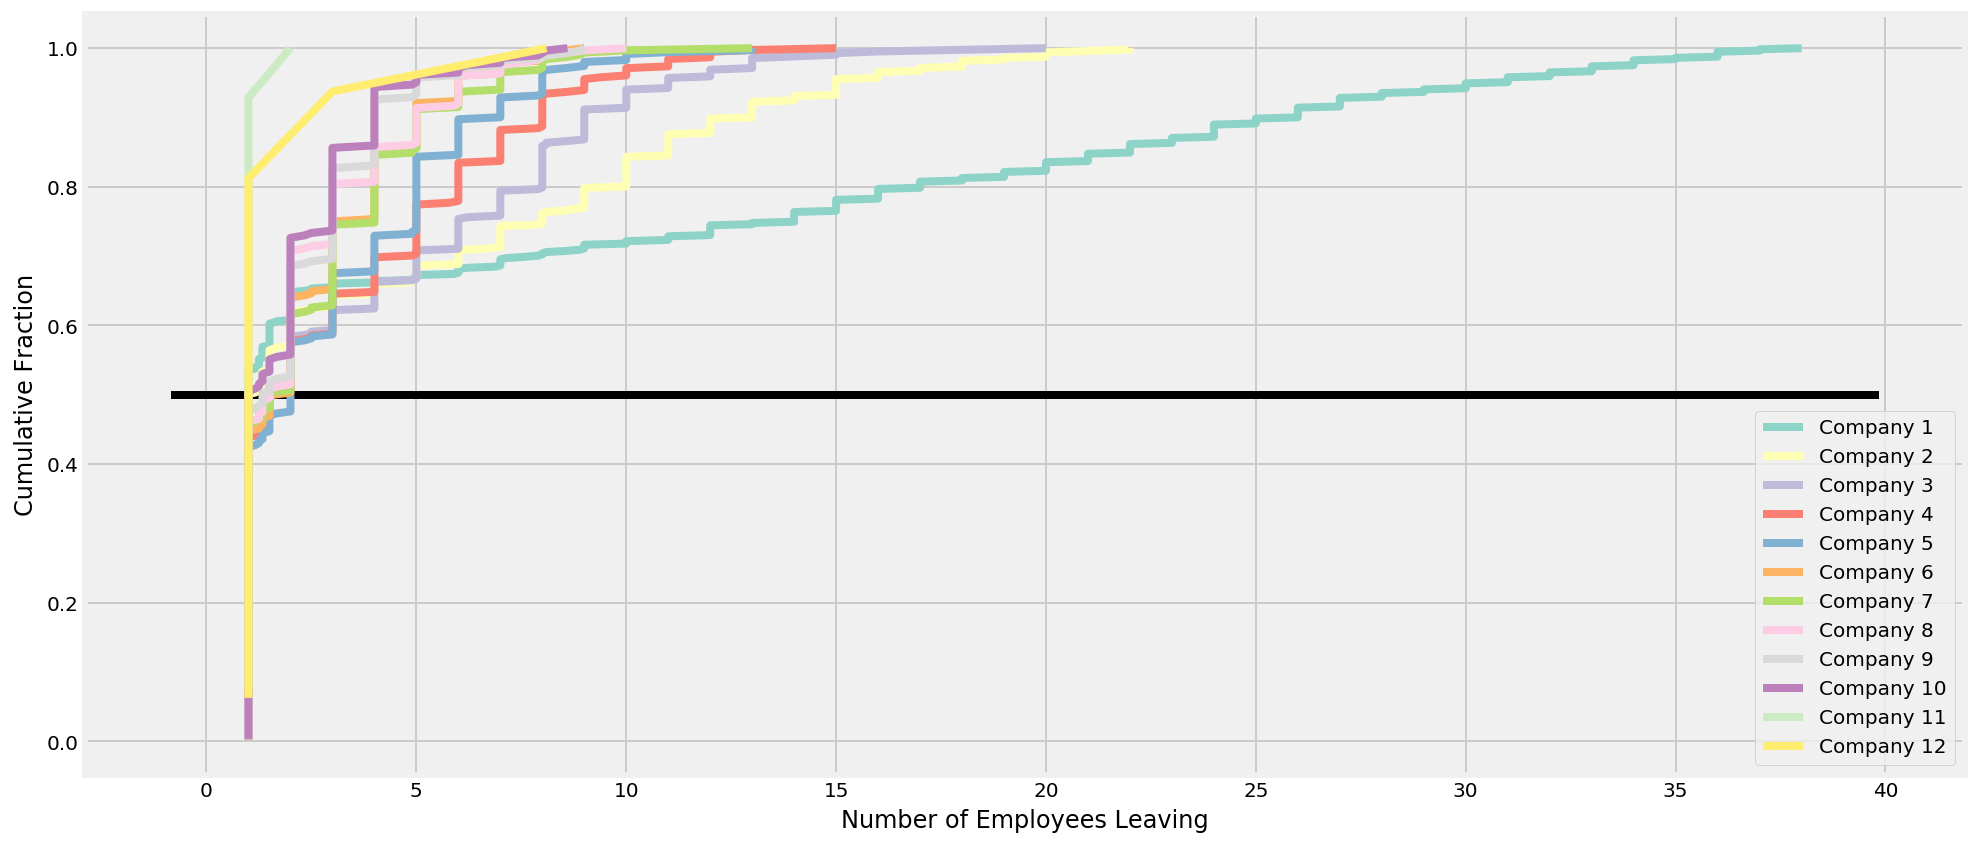

In [15]:
def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data) + 1) / len(data)
    return x, y


fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

for i in range(1, 13):
    x, y = ecdf(removed_over_time.loc[:, i].replace(0, np.nan).dropna())
    ax.plot(x, y, label='Company {i}'.format(i=i), color=Set3.colors[i - 1])

ax.hlines(xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], y=0.5, color='black')
ax.legend()
ax.set_xlabel('Number of Employees Leaving')
ax.set_ylabel('Cumulative Fraction')

At large companies, about half of employees leave alone, and that about half of employees leave together.

At small companies, employees tend to leave alone.

# Head Counts over Time

Let's now make a `headcount_table` that shows the number employees each company has at each time point.

In [16]:
headcount_table = headcounts_over_time.stack().reset_index()
headcount_table.columns = ['date', 'company_id', 'headcount']
headcount_table.head(12)

,date,company_id,headcount
0,2011-01-24,1,25.0
1,2011-01-24,2,17.0
2,2011-01-24,3,9.0
3,2011-01-24,4,12.0
4,2011-01-24,5,5.0
5,2011-01-24,6,3.0
6,2011-01-24,7,1.0
7,2011-01-24,8,6.0
8,2011-01-24,9,3.0
9,2011-01-24,10,0.0


# Survival Analysis

Let's do a survival analysis! Firstly, I want to plot survival curves for all companies together.

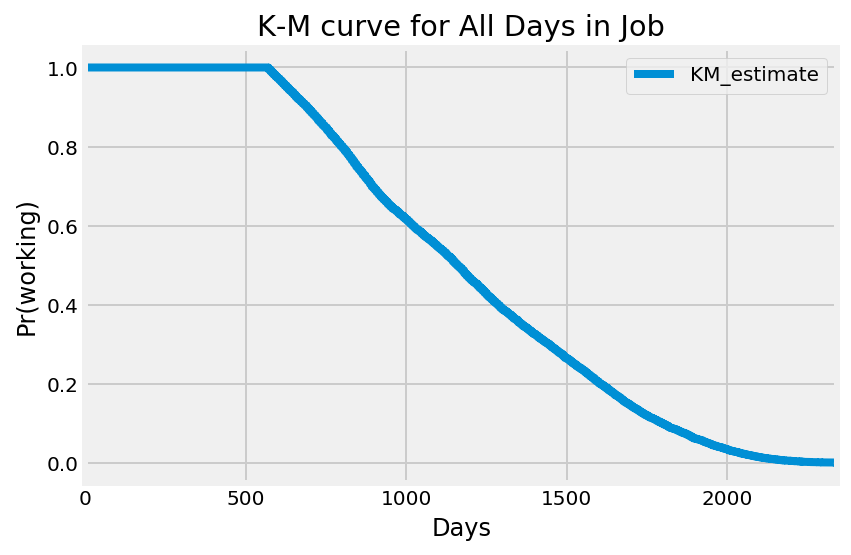

In [18]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(data['days_in_job'], event_observed=data['censored'])
ax = kmf.plot()
ax.set_title('K-M curve for All Days in Job')
ax.set_xlabel('Days')
ax.set_ylabel('Pr(working)')

Now, I would like to plot one for every department, one company at a time.

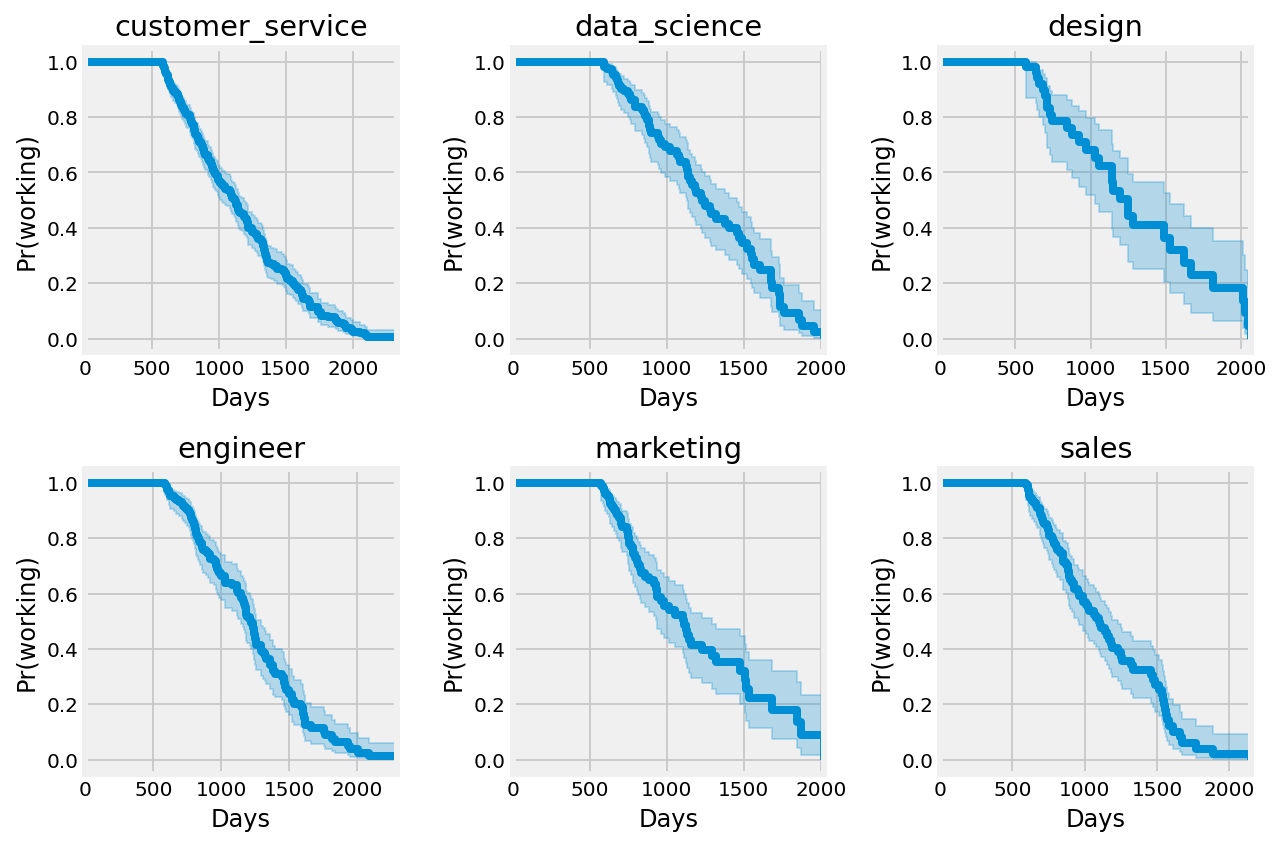

In [50]:
from matplotlib.gridspec import GridSpec
kmf_grouped = KaplanMeierFitter()

groups = sorted(set(data['dept'].values))

gs = GridSpec(nrows=2, ncols=3)

fig = plt.figure(figsize=(9,6))

for i, g in enumerate(groups):
    ax = fig.add_subplot(gs[i])
    cond = (data['dept'] == g) & (data['company_id'] == 6)
    grp = data[cond]
    kmf.fit(grp['days_in_job'], 
            event_observed=grp['censored'], 
            label=str(g))
    kmf.plot(ax=ax, legend=None)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Pr(working)')
    ax.set_title(g)

plt.tight_layout()

In [65]:
import patsy

X = patsy.dmatrix('dept + seniority + salary -1', 
                  data, 
                  return_type='dataframe')
X

,dept[customer_service],dept[data_science],dept[design],dept[engineer],dept[marketing],dept[sales],seniority,salary
0,1.0,0.0,0.0,0.0,0.0,0.0,28.0,89.0
1,0.0,0.0,0.0,0.0,1.0,0.0,20.0,183.0
2,0.0,0.0,0.0,0.0,1.0,0.0,14.0,101.0
3,1.0,0.0,0.0,0.0,0.0,0.0,20.0,115.0
4,0.0,1.0,0.0,0.0,0.0,0.0,23.0,276.0
5,0.0,1.0,0.0,0.0,0.0,0.0,14.0,165.0
6,1.0,0.0,0.0,0.0,0.0,0.0,21.0,107.0
7,1.0,0.0,0.0,0.0,0.0,0.0,4.0,30.0
8,0.0,0.0,0.0,1.0,0.0,0.0,7.0,160.0
9,0.0,0.0,0.0,0.0,0.0,1.0,7.0,104.0


Let's now use the `Cox Proportional Hazards` model.

In [66]:
from lifelines import CoxPHFitter

cpf = CoxPHFitter()

X['censored'] = data['censored']
X['days_in_job'] = data['days_in_job']

cpf.fit(X, 'days_in_job', event_col='censored')

<lifelines.CoxPHFitter: fitted with 24702 observations, 13510 censored>

In [62]:
cpf.baseline_cumulative_hazard_.tail()

,baseline hazard
event_at,
2307.0,2.646577
2328.0,2.697040
2334.0,2.759596
2335.0,2.906755
2342.0,3.411280


In [64]:
cpf.print_summary()

n=24702, number of events=11192

                             coef  exp(coef)  se(coef)          z         p  lower 0.95  upper 0.95   
dept[customer_service] -4.028e-01  6.685e-01       nan        nan       nan         nan         nan   
dept[data_science]     -2.886e-01  7.493e-01       nan        nan       nan         nan         nan   
dept[design]           -1.947e-01  8.231e-01       nan        nan       nan         nan         nan   
dept[engineer]         -3.329e-01  7.168e-01       nan        nan       nan         nan         nan   
dept[marketing]        -2.682e-01  7.647e-01       nan        nan       nan         nan         nan   
dept[sales]            -2.656e-01  7.668e-01       nan        nan       nan         nan         nan   
company_id             -3.218e-03  9.968e-01 1.005e-02 -3.202e-01 7.488e-01  -2.291e-02   1.648e-02   
seniority               3.045e-02  1.031e+00 1.484e-02  2.053e+00 4.012e-02   1.367e-03   5.954e-02  *
salary                 -4.522e-02  9.558

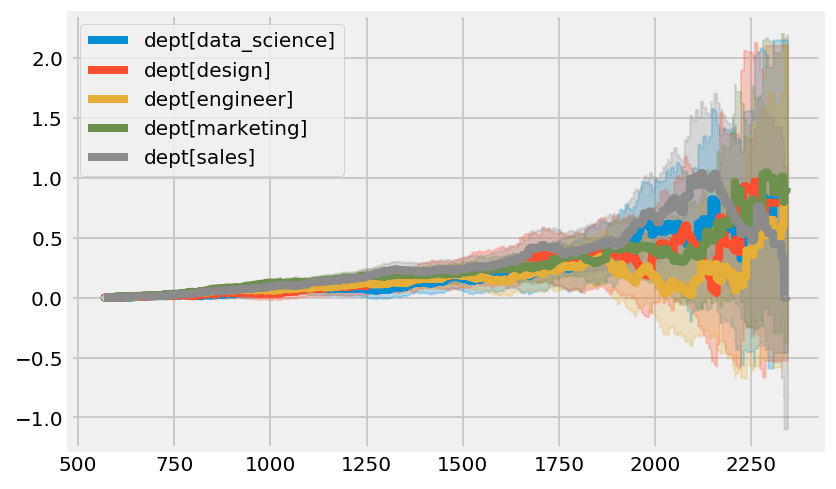

In [56]:
aaf.plot(columns=['dept[data_science]', 'dept[design]', 
                  'dept[engineer]', 'dept[marketing]',
                  'dept[sales]'])

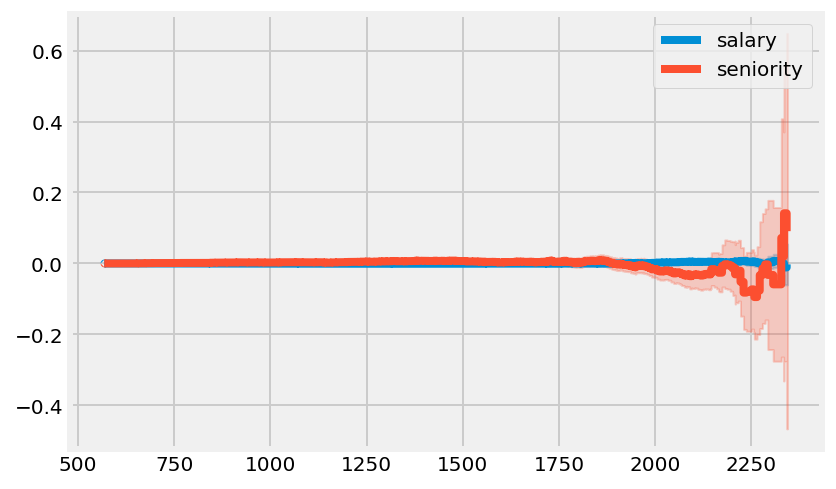

In [38]:
aaf.plot(columns=['salary', 'seniority'])

In [40]:
from lifelines.utils import k_fold_cross_validation

scores = k_fold_cross_validation(aaf, X, 'days_in_job', event_col='censored', k=5)
print(scores)

 [-----------------100%-----------------] 8953 of 8953 complete in 102.3 sec
 [-----------------100%-----------------] 8953 of 8953 complete in 85.3 sec
 [-----------------100%-----------------] 8955 of 8954 complete in 143.1 sec
 [-----------------100%-----------------] 8954 of 8954 complete in 124.6 sec
 [-----------------100%-----------------] 8954 of 8954 complete in 105.1 sec
[0.52453689222044431, 0.50799156654916111, 0.50968106838167515, 0.51364075280789956, 0.52944239386656333]


# By Employee

Do we know whether there are certain employees who are prone to leaving their job? Maybe some have spectacular stability, while others tend to hop around often? 

In [22]:
# How many unique employee IDs are there?

len(set(data['employee_id'])), len(data)

(24702, 24702)

As it turns out, there are {{ len(set(data['employee_id'])) }} employee IDs in the data table, and {{ len(data) }} records in the data table. This probably implies that we can't answer this question using the data available, because there are no records of the same employee in two different jobs at the companies listed.